# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [1]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [3]:
!pip -q install git+https://github.com/tensorflow/privacy

     |████████████████████████████████| 4.0 MB 9.1 MB/s 


In [4]:
!pip -q install git+https://github.com/qubvel/classification_models.git

     |████████████████████████████████| 50 kB 4.8 MB/s 


##### Import libraries

In [5]:
import os, random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from classification_models.tfkeras import Classifiers

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SingleAttackResult
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

In [6]:
ResNet18, _ = Classifiers.get('resnet18')

##### Define constants

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Model parameters
BATCH_SIZE = 32
IMG_SHAPE = [32, 32, 3] # original dataset image size is 28x28x1
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 0.88
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Load dataset

In [8]:
(train_ds, test_ds), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [9]:
TRAIN_IMG_COUNT = ds_info.splits['train'].num_examples
TEST_IMG_COUNT = ds_info.splits['test'].num_examples
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 50000, Test: 10000


### Prepare for training

###### Define preprocessing

In [14]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Prepare batches

In [15]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return ds

In [16]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                cache='./data.tfcache')

test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True)

In [17]:
# set for attack on train set
train_attack_data = prepare_dataset(train_ds,
                                    pre=True,
                                    shuffle=False,
                                    repeat=False,
                                    batch=1,
                                    cache=False)

# set for attack on test set
test_attack_data = prepare_dataset(test_ds,
                                   pre=True,
                                   shuffle=False,
                                   repeat=False,
                                   batch=1,
                                   cache=False)

### Visualization

###### Images from a training batch

In [18]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(5,5))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        plt.axis("off")

In [19]:
image_batch, label_batch = next(iter(train_batched))

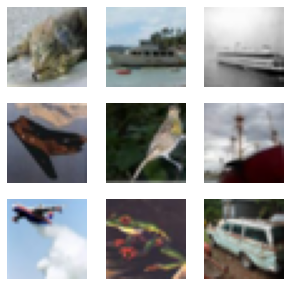

In [20]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Learning rate decay

In [21]:
learning_rate_decay = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1, min_lr=1e-6)

## ResNet18
[Paper](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)

### Model definition

In [22]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('tanh', name=name + '_preact_tanh')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride, name=name + 'pool_pool')(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('tanh', name=name + '_1_tanh')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('tanh', name=name + '_2_tanh')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    # bottom
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    # body
    x = stack_fn(x)
    # no top added
    # Create model
    model = tf.keras.models.Model(input, x, name=model_name)
    return model
    
def ResNet18_tanh(input):
    def stack_fn(x):
        x = resnet_stack(x, 64, 2, name='conv2')
        x = resnet_stack(x, 128, 2, name='conv3')
        x = resnet_stack(x, 256, 2, name='conv4')
        x = resnet_stack(x, 512, 2, stride1=1, name='conv5')
        x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
        x = Activation('tanh', name='post_tanh')(x)
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [23]:
def resnet18_builder(weights=False, dropout=False, activation='relu', name='ResNet18'):
    # ResNet18 without head
    if activation == 'tanh':
        resnet18 = ResNet18_tanh(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    elif activation == 'relu':
        _weights = False if weights == 'pneumonia' else weights
        resnet18 = ResNet18(include_top = False,
                            weights = _weights,
                            input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    
    resnet18.trainable = True # make layers trainable

    seq = [
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]), name='Input'),
        resnet18, # add resnet18 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=10, activation='softmax', name='Output'), # add classification layer for MNIST
    ]

    if dropout:
        seq.insert(3, Dropout(rate=dropout, name='Dropout')) # add dropout (inspired by inception-resnet-v2))

    model = Sequential(seq, name=name)

    # load weights from pneumonia pretraining
    if weights == 'pneumonia' and activation == 'relu':
        model.load_weights(weights_path+'resnet18_relu_public_weights.h5', by_name=True)
    if weights == 'pneumonia' and activation == 'tanh':
        model.load_weights(weights_path+'resnet18_tanh_public_weights.h5', by_name=True)
    
    return model

In [24]:
resnet18 = resnet18_builder(name='ResNet18')
resnet18_dropout = resnet18_builder(dropout=0.2, name='ResNet18-dropout')
resnet18_imagenet = resnet18_builder(weights='imagenet', name='ResNet18-imagenet')
#resnet18_pneumonia = resnet18_builder(weights='pneumonia', name='ResNet18-pneumonia')

resnet18_tanh = resnet18_builder(activation='tanh', name='ResNet18-tanh')
resnet18_tanh_dropout = resnet18_builder(activation='tanh', dropout=0.2, name='ResNet18-tanh-dropout')
#resnet18_tanh_pneumonia = resnet18_builder(activation='tanh', weights='pneumonia', name='ResNet18-tanh-pneumonia')

models = [
    resnet18,
    #resnet18_dropout,
    #resnet18_imagenet,
    #resnet18_pneumonia,
    #resnet18_tanh,
    #resnet18_tanh_dropout,
    #resnet18_tanh_pneumonia,
]

METRICS = [
    'accuracy',
    #Precision(name='precision'),
    #Recall(name='recall')
]

for model in models:
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

44933120/44920640 [==============================] - 0s 0us/step


In [25]:
models[0].summary()

Model: "ResNet18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1, 1, 512)         11186889  
                                                                 
 AvgPool (GlobalAveragePooli  (None, 512)              0         
 ng2D)                                                           
                                                                 
 Output (Dense)              (None, 10)                5130      
                                                                 
Total params: 11,192,019
Trainable params: 11,184,077
Non-trainable params: 7,942
_________________________________________________________________


### Training

In [26]:
for model in models:
    print("Training %s ..." % (model.name))
    history = model.fit(
        train_batched,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = [learning_rate_decay],
    )
    print('\n')

Training ResNet18 ...
Epoch 1/20
1562/1562 [==============================] - 51s 21ms/step - loss: 1.4031 - accuracy: 0.4992 - lr: 0.0010
Epoch 2/20
1562/1562 [==============================] - 29s 19ms/step - loss: 1.0093 - accuracy: 0.6495 - lr: 0.0010
Epoch 3/20
1562/1562 [==============================] - 29s 19ms/step - loss: 0.8260 - accuracy: 0.7165 - lr: 0.0010
Epoch 4/20
1562/1562 [==============================] - 29s 19ms/step - loss: 0.6872 - accuracy: 0.7632 - lr: 0.0010
Epoch 5/20
1562/1562 [==============================] - 29s 19ms/step - loss: 0.5772 - accuracy: 0.8030 - lr: 0.0010
Epoch 6/20
1562/1562 [==============================] - 29s 19ms/step - loss: 0.4694 - accuracy: 0.8374 - lr: 0.0010
Epoch 7/20
1562/1562 [==============================] - 29s 18ms/step - loss: 0.3750 - accuracy: 0.8711 - lr: 0.0010
Epoch 8/20
1562/1562 [==============================] - 29s 18ms/step - loss: 0.3060 - accuracy: 0.8932 - lr: 0.0010
Epoch 9/20
1562/1562 [====================

## Evaluation

In [27]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc = model.evaluate(test_batched)
    print('\n')

Evaluating ResNet18 ...
313/313 [==============================] - 4s 10ms/step - loss: 1.2286 - accuracy: 0.7586




### Privacy Analysis

#### Compute epsilon

In [28]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-5

In [29]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [30]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-05, Epsilon = 1.055


In [31]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 1.0
noise = compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)
print(noise)

DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.9000766998803615 iterated over 31250 steps satisfies differential privacy with eps = 1 and delta = 1e-05.
0.9000766998803615


#### Membership Inference Attack

In [32]:
def compute_attack_inputs(model, attack_data):
    scc = tf.keras.backend.sparse_categorical_crossentropy
    constant = tf.keras.backend.constant
    # get labels
    labels = []
    for x, y in attack_data.as_numpy_iterator():
        labels.append(y[0])
    # predict
    probs = model.predict(attack_data)
    # compute loss
    losses = scc(constant([[y] for y in labels]), constant(probs), from_logits=False).numpy()
    
    return (np.array(probs), np.array(losses), np.array(labels))

# run membership inference attack
def run_mia(model, train_attack_input, test_attack_input):
    # prepare attacks
    probs_train, loss_train, labels_train = train_attack_input
    probs_test, loss_test, labels_test = test_attack_input

    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = labels_train,
        labels_test = labels_test
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,
        by_percentiles = False,
        by_classification_correctness = True
    )

    attack_types = [
        #AttackType.THRESHOLD_ATTACK, # logistic was always better, so no threshold to save time
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    #plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    #plt.show()

    # print a user-friendly summary of the attacks
    #print(attacks_result.summary(by_slices=False))

    max_auc = attacks_result.get_result_with_max_auc().get_auc()
    max_adv = attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

    return max_auc, max_adv

# epsilon estimation based on attack, metric adapted for AUC from https://paperswithcode.com/paper/antipodes-of-label-differential-privacy-pate
def empirical_eps(auc):
    if auc <= 0.5:
        return 0
    if auc == 1:
        return np.inf
    return np.log(auc / (1 - auc))

from contextlib import contextmanager
import sys
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [33]:
import scipy.stats as st

for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    SAMPLE_NB = 100
    
    train_attack_input = compute_attack_inputs(model, train_attack_data)
    test_attack_input = compute_attack_inputs(model, test_attack_data)

    aucs = []
    advs = []
    emp_eps = []
    for i in range(SAMPLE_NB):
        with suppress_stdout():
            max_auc, max_adv = run_mia(model, train_attack_input, test_attack_input)
        aucs.append(max_auc)
        advs.append(max_adv)
        emp_eps.append(empirical_eps(max_auc))

    auc_low, auc_high = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs))
    adv_low, adv_high = st.t.interval(0.95, len(advs)-1, loc=np.mean(advs), scale=st.sem(advs))
    eps_low, eps_high = st.t.interval(0.95, len(emp_eps)-1, loc=np.mean(emp_eps), scale=st.sem(emp_eps))

    print('95%%-CI based on %i attack samples'%(SAMPLE_NB))
    print('AUC: %0.2f-%0.2f'%(auc_low, auc_high))
    print('Attacker advantage: %0.2f-%0.2f'%(adv_low, adv_high))
    print('Empirical epsilon bounds from AUC: %0.2f-%0.2f\n'%(eps_low, eps_high))

Membership Inference Attack on ResNet18...


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

95%-CI based on 100 attack samples
AUC: 0.79-0.79
Attacker advantage: 0.48-0.49
Empirical epsilon bounds from AUC: 1.30-1.34

